In [35]:
# Imports
import numpy as np
from scipy.integrate import solve_ivp
from scipy import sparse
import matplotlib.pyplot as plt
from matplotlib import animation
import easygui as eg

In [36]:
def arraymax2(fun_t, t_range):
    return np.array([np.abs(fun_t[:,t]).max() for t in t_range]).mean()

In [37]:
params = eg.multenterbox("Enter simulation params",
                         fields=["dt [micro seconds], primary source of runtime for redering animation",
                                 "total time [milli seconds]", "dz [microns], primary source of runtime for solve_ivp"],
                         values=[1, 6, 100])
# Set up simulation params. 
"""Time step size and total time is primary source of runtime for rendering animation"""
dt = float(params[0]) * 1e-6 # time step size, seconds
t0 = 0.0
tf = float(params[1]) * 1e-3 # total time evolution, seconds
t_eval = np.arange(t0, tf, dt)
t_range = range(len(t_eval))

"""Wire step size is primary source of runtime for solve_ivp"""
dz = float(params[2]) * 1e-6 # wire step size, meters

# Define initial conditions of detector
""" 
Defaults source:
https://www.tribology-abc.com/calculators/properties_of_common_spring_materials.pdf <-- ASTM A228
https://optimumspring.com/technical_resources/materials/carbon_steels/music_wire_228_spring_wire.aspx <-- For mass density 
"""
params = eg.multenterbox("Enter wire params", 
                         fields=["Length [m]", "Mass Density [kg / m^3]", "Tensile strength [MPa]", "Youngs Modulus [GPa]", "Wire Diameter [mm]"],
                         values=[2, 7850, 2751, 207, 0.004])
l = float(params[0]) # length of wire, meters
rho = float(params[1]) # mass density, kg/m^3
tensile_str = float(params[2]) * 10**6 # Tensile Strength of wire, Pa
young_mod = float(params[3]) * 10**9 # elastic modulus of wire, Pa
dia = float(params[4]) * 10**-3 # diameter of wire, meters
cs_area = np.pi * dia**2 / 4 # cross sectional area of wire, m^2

mu = rho * cs_area # linear mass density, kg/m
tension = 0.1 * tensile_str * cs_area # Tension on wire, N
v_press = np.sqrt(young_mod / rho) # wavespeed for longitudinal wave, m/s
v_shear = np.sqrt(tension / mu) # wavespeed for transverse waves, m/s

wire_props = (f"Length {l:.2e} m || pressure wave speed {v_press:1.2e} m/s || shear wave speed {v_shear:.2e}")
# Impact conditions of particle and track
# TODO: Make 0 custom option
relativistic = (3e8, 1.782e-24) # c [m/s], 1 TeV/c^2 [kg]
thermal_neut = (1919.62, 1.674e-27) # [m/s], [kg] --> T = 298 K, mv^2 = (3/2) k_b T
gal_orbit = (220e3, 1.782e-24) # [m/s], 1 TeV/c^2 [kg]
parts = [None, relativistic, thermal_neut, gal_orbit]
ret = eg.integerbox("Which particle?\n0: Custom\n1: Relativistic DM\n2: Thermal Neutron\n3: Galactic Orbit DM",
                    default=1, lowerbound=0, upperbound=3)
titles = ["Custom", "Relativistic DM", "Thermal Neutron", "Galactic Orbit DM"]
title_label = titles[ret]
if ret == 0:
    custom= eg.multenterbox("Enter custom particle params",
                             fields=["Mass, [kg]", "Speed, [m/s]"],
                             values=[1,1])
    parts[0] = (float(custom[1]), float(custom[0]))
G = 6.67430e-11 # gravitational constant
M = parts[ret][1] # mass of inciting particle, meters/second
v_p = parts[ret][0] # velocity of inciting particle, meters / second


params = eg.multenterbox("Enter impact params", 
                         fields=["z0 (track/wire 'intersection') [m]", "b (dist. of closest approach) [m]", "theta (angle between track and wire) [degrees]", "phi (rot. about wire) [degrees] NOT IMPLEMENTED"],
                         values=[l/4, 0.05, 45, 90])
# TODO: Integrate phi and rotations
z0 = float(params[0]) # position of particle track and wire 'intersection', meters
b = float(params[1]) # shortest distance between wire and particle track, meters
theta = float(params[2]) * (np.pi / 180) # Angle between particle track and z (wire) axes, radians
phi = float(params[3]) * (np.pi / 180) # Angle between particle track and x axes, radians
zwire = np.arange(0 - z0, l - z0, dz) # define wire along z axes s.t. z0 is at z_string == 0
arrdim = zwire.size
z_ind = arrdim * 3//8
z_t = zwire[z_ind]
costheta = np.cos(theta)
sintheta = np.sin(theta)
cosphi = np.cos(phi)
sinphi = np.sin(phi)
impact_props = (f"wire 'intersection' {z0:.2e} m || minimum distance {b:.2e} m \n"
                f"theta (track polar angle) {theta * 180 / np.pi :.2e} degrees || phi (track azimuthal(?) angle) {theta * 180 / np.pi :.2e} degrees")

In [38]:
small = G * M / v_p
def denom(v, direction):
    return (b**2 + (z_t + direction * v * t_eval)**2 * sintheta**2)

xnum1 = costheta * sintheta * sinphi
def xnum2(direction):
    return (2 * (z_t + direction * v_shear * t_eval) * sintheta**2 * (b * cosphi + (z_t + direction * v_shear * t_eval) * costheta * sintheta * sinphi))
ax_left = v_shear * (xnum1 / denom(v_shear, 1) - xnum2(1) / denom(v_shear, 1)**2) # left moving wave
ax_right = v_shear * (- xnum1 / denom(v_shear, -1) + xnum2(-1) / denom(v_shear, -1)**2) # right moving wave
ax = ax_right

ynum1 = costheta * sintheta * cosphi
def ynum2(direction):
    return (2 * (z_t + direction * v_shear * t_eval) * sintheta**2 * (b * sinphi - (z_t + direction * v_shear * t_eval) * costheta * sintheta * cosphi))
ay_left = v_shear * (- ynum1 / denom(v_shear, 1) - ynum2(1) / denom(v_shear, 1)**2)
ay_right = v_shear * (ynum1 / denom(v_shear, -1) + ynum2(-1) / denom(v_shear, -1)**2)
ay = ay_right

znum1 = sintheta**2
def znum2(v, direction):
    return (-2 * (z_t + direction * v * t_eval)**2 * sintheta**4)
az_left = v_press * (-znum1 / denom(v_press, 1) - znum2(v_press, 1) / denom(v_press, 1)**2)
az_right = v_press * (znum1 / denom(v_press, -1) + znum2(v_press, -1) / denom(v_press, -1)**2)
az = az_right

print(ax.max(), ay.max(), az.max())


4680.048635163543 34391.125099952886 1025406.1617919597


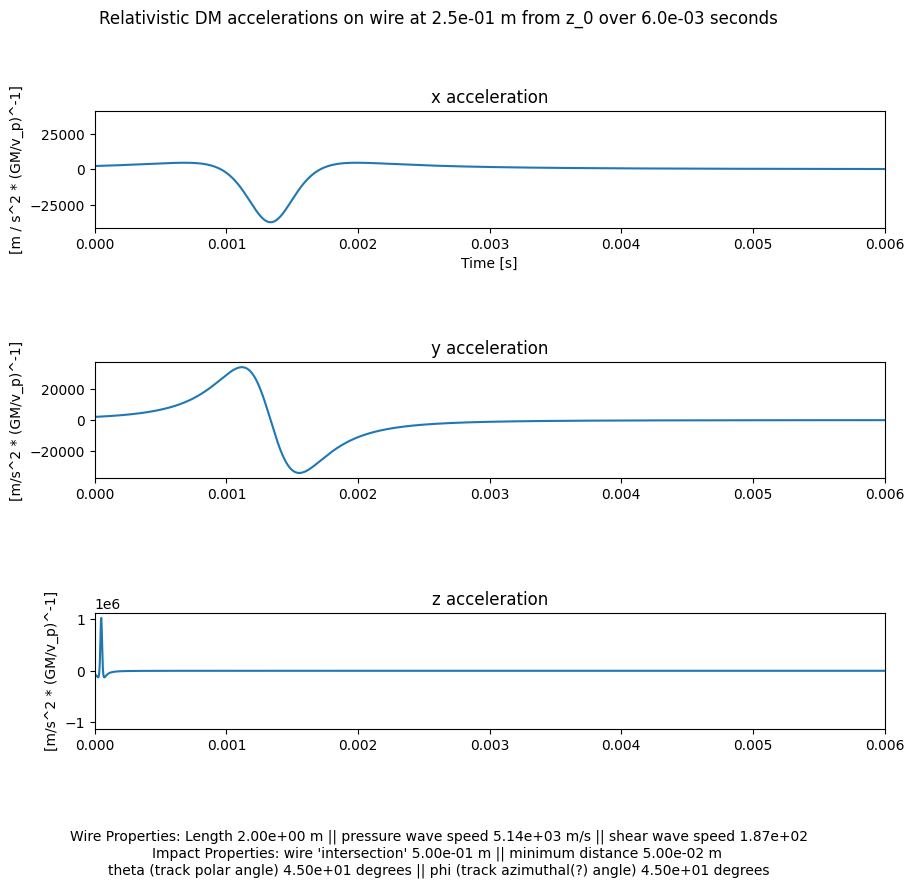

In [39]:
# Figure
fig1, (ax1, ax2, ax3) = plt.subplots(3,1)
ax1.set_xlabel('Time [s]')
# multiply maximums by 1.1 to give a little padding
t_range = range(len(t_eval))
x_max = np.abs(ax).max() * 1.1
y_max = np.abs(ay).max() * 1.1
z_max = np.abs(az).max() * 1.1

# Plot accerlations
ax1.plot(t_eval, ax)
ax2.plot(t_eval, ay)
ax3.plot(t_eval, az)
# Graph aesthetics
ax1.set_ylim(-x_max, x_max)
ax1.set_xlim(t0, tf)
ax1.set_title('x acceleration')
ax1.set_ylabel(f'[m / s^2 * (GM/v_p)^-1]')

ax2.set_ylim(-y_max, y_max)
ax2.set_xlim(t0, tf)
ax2.set_title('y acceleration')
ax2.set_ylabel(f'[m/s^2 * (GM/v_p)^-1]')

ax3.set_ylim(-z_max, z_max)
ax3.set_xlim(t0, tf)
ax3.set_title('z acceleration')
ax3.set_ylabel('[m/s^2 * (GM/v_p)^-1]')

fig1.text(0.5,-.1, s = f"Wire Properties: {wire_props}\nImpact Properties: {impact_props}", ha='center')
fig1.suptitle(f'{title_label} accelerations on wire at {z_t:.1e} m from z_0 over {tf:.1e} seconds')
fig1.tight_layout()
fig1.set_figwidth(10)
fig1.set_figheight(8)
# fig1.show()